In [1]:
# GPM 3B-CMB reading, first attempt Aug 2018
# cleaned up code before submission of manuscript, mid dec 2018 dduncan
# (code produces 2pan 3d plots of Dm and Nw comparing OceanRAIN and GPM CMB, Fig 2 in manuscript)

import h5py
import glob
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors


/home/dudavid/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dire = '/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM'

# for filespec details, best to go here (page 1947): https://pps.gsfc.nasa.gov/Documents/filespec.GPM_V5.pdf

cmb_files = glob.glob(dire+'/3B_CMB/*.HDF5')
#print(cmb_files[0],cmb_files[3])


/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM/3B_CMB/3B-MO.GPM.DPRGMI.CORRAGM.20170101-S000000-E235959.01.V05A.HDF5 /home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM/3B_CMB/3B-MO.GPM.DPRGMI.CORRAGM.20170401-S000000-E235959.04.V05A.HDF5


In [3]:
# make low-res and high-res grids for multimonth means, weighted by counts per month so as to be fair
# low res grid goes 70S to 70N, high res grid goes 67S to 67N
xl,yl = 72,28
xh,yh = 1440,536  # things don't look markedly different in hi-res product, just noisier and takes longer

nb = 30 
# 3B_CMB histogram bins for Dm:
binz = np.append(np.arange(0.1,3.01,0.1),4.0)[0:nb]
print(binz,len(binz))

# unitless, for n(D) in m^-4
nbnz = np.array([4.0,    4.2,    4.4,    4.6,    4.8,    5.0,     \
              5.2,    5.4,    5.6,    5.8,    6.0,    6.2,     \
              6.4,    6.6,    6.8,    7.0,    7.2,    7.4,     \
              7.6,    7.8,    8.0,    8.2,    8.4,    8.6,  \
              8.8,    9.0,    9.2,    9.4,    9.6,    10.0 ])
# shift from m^-4 to mm^-1 m^-3:
nbnz -= 3
print(nbnz,len(nbnz))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ] 30
[1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4
 4.6 4.8 5.  5.2 5.4 5.6 5.8 6.  6.2 6.4 6.6 7. ] 30


(92116,)
['0.00E+2', '3.00E+1', '1.43E+1', '8.91E+0']
8217
8507
7179
10616
11078
6205
4877
5047
10340
9190
6766
4094
1.0 1500.0 1


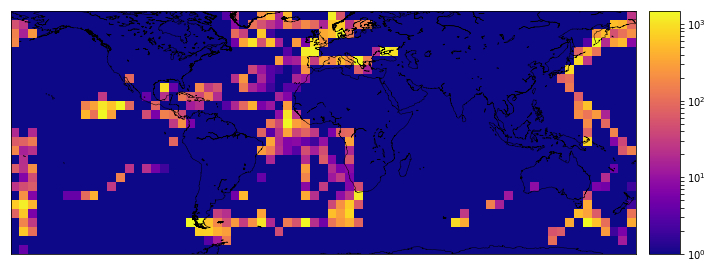

In [4]:
# quantify the density of OR obs within level 3 monthly grid boxes
typ = 'MSs3'
dir_raw_data = "/home/dudavid/projects/dsd/dj/data/"
olo = np.load(dir_raw_data+'alllond'+typ+'.npy')# [::per]
ola = np.load(dir_raw_data+'alllatd'+typ+'.npy')# [::per]
odate = np.load(dir_raw_data+'alldatd'+typ+'.npy')# [::per] # date: DDMMYYYY
months = np.array([int(str(x)[-5:-7:-1][::-1])-1 for x in odate]) # month indices starting at 0 for jan
print(np.shape(months))
dgrid = np.zeros([xl,yl,12])
startlat, gsize = 70, 5
ladex = np.round((ola[:]+startlat-gsize*.5) / gsize)
lodex = np.round((olo[:]+180.0-gsize*.5) / gsize)
print(info(ladex))
for t in range(12):
    tsub = np.where( months == t)#[0]
    #tsubset = odate[tsub]
    print(len(odate[tsub]))
    for x in range(xl):
        if np.any(lodex[tsub] == x):
            dexsub = np.where(lodex[tsub] == x)
            #subset = odate[dexsub]  
            #subsetla = ladex[tsub][dexsub]
            for y in range(yl):
                if np.any(ladex[tsub][dexsub] == y):
                    lolasubset = np.where(ladex[tsub][dexsub] == y)
                    dgrid[x,y,t] += len(ladex[tsub][dexsub][lolasubset])
#plt.figure(figsize=[12,7])
#grdmap(np.transpose(np.sum(dgrid[:,:,:],axis=2)),-180,-70, 1, 1.5e3, 1)

In [5]:
# arrays are "st,rt,hgt,ns,lnL,ltL" where st= sfc type (ocean,land,all), 
#   rt= rain type (str/conv/all), hgt= alt. index (0=sfc,1-10=km levels, above are different), 
#   ns = # swaths (MS (ku+ka+gmi), NS (ku+gmi)), lnL= longitude Lo, ltL= latitude Lo
# G1 is 5deg boxes, G2 is 0.25deg boxes
st=0  #ocean
rt=1  #all (strat and conv)
hgt=0 #near-sfc
ns=1  #MS(0) or NS(1) swath of DPR

mlowdm, mlownw = np.zeros([xl,yl]),np.zeros([xl,yl])
mlowdm_up = np.zeros([xl,yl])
lowcD_up = np.zeros([xl,yl])
mhidm, mhinw = np.zeros([xh,yh]),np.zeros([xh,yh])
lowcD, lowcN = np.zeros([xl,yl]),np.zeros([xl,yl])
nlt = 6 #   number of lat bins
allhist = np.zeros([nb,nlt]) # 30 gpm-defined bins, lat bins 20deg each (60S-60N)
allhistnw = np.zeros([nb,nlt]) # 30 gpm-defined bins, lat bins 20deg each (60S-60N)
    
for fi in range(len(cmb_files)): 
    f = h5py.File(cmb_files[fi])
    print(cmb_files[fi]) # to make sure they run in order!
    g1 = f['Grids/G1']
    g2 = f['Grids/G2']
    DmLoH= np.array(g1['precipTotDm/hist'])[:,st,rt,hgt,ns,:,:]  #[nhis,st,rt,hgt,ns,:,:]
    NwLoH= np.array(g1['precipTotLogNw/hist'])[:,st,rt,hgt,ns,:,:]  #[nhis,st,rt,hgt,ns,:,:]
    for b in range(nb):
        # zero out the counts for grid boxes where OR didn't have observations:
        #scgrid = np.sum(dgrid[:,:,:],axis=2)
        scgrid = dgrid[:,:,fi]
        new_DmLoH = DmLoH[b,:,:]
        new_DmLoH[ scgrid == 0 ] = 0
        new_NwLoH = NwLoH[b,:,:]
        new_NwLoH[ scgrid == 0 ] = 0
        for y in range(nlt):    # hardcoded starting -60 (since grid starts -70), up by 20s
            allhist[b,y] += np.sum(new_DmLoH[:,(2+y*4):(2+(y+1)*4)]) # -60 to -40, -40 to -20, up to 80
            allhistnw[b,y] += np.sum(new_NwLoH[:,(2+y*4):(2+(y+1)*4)]) 
            #allhist[b,y] = np.sum(new_DmLoH[b,:,(2+y*4):(2+(y+1)*4)]) # -60 to -40, -40 to -20, up to 80
            #allhistnw[b,y] = np.sum(new_NwLoH[b,:,(2+y*4):(2+(y+1)*4)]) 
    print(np.sum(allhist[:,nlt-1]), fi)
            
#    DmLo = np.array(g1['precipTotDm/mean'])[st,rt,hgt,ns,:,:] # Dm is volume-weighted mean [mm]
#    DmLo_up = np.array(g1['precipTotDm/mean'])[st,rt,hgt+2,ns,:,:] 
#    DmLoC_up = np.array(g1['precipTotDm/count'])[st,rt,hgt+2,ns,:,:]
#    DmLoS= np.array(g1['precipTotDm/stdev'])[st,rt,hgt,ns,:,:]
#    DmLoC= np.array(g1['precipTotDm/count'])[st,rt,hgt,ns,:,:]
#    NwLo = np.array(g1['precipTotLogNw/mean'])[st,rt,hgt,ns,:,:] # Nw given as logNw [m^-4]
#    NwLoS= np.array(g1['precipTotLogNw/stdev'])[st,rt,hgt,ns,:,:]
#    NwLoC= np.array(g1['precipTotLogNw/count'])[st,rt,hgt,ns,:,:]
#    # high-res doesn't have land/ocean/all index:
#    #DmHi = np.array(g2['precipTotDm/mean'])[rt,hgt,ns,:,:] # Dm is volume-weighted mean [mm]
#    #DmHiS= np.array(g2['precipTotDm/stdev'])[rt,hgt,ns,:,:]
#    #DmHiC= np.array(g2['precipTotDm/count'])[rt,hgt,ns,:,:]
#    #NwHi = np.array(g2['precipTotLogNw/mean'])[rt,hgt,ns,:,:] # Nw given as logNw [m^-4]
#    #NwHiS= np.array(g2['precipTotLogNw/stdev'])[rt,hgt,ns,:,:]
#    #NwHiC= np.array(g2['precipTotLogNw/count'])[rt,hgt,ns,:,:]
#    # a good subset for these is [st=0,rt=2,hgt=0,ns=0,:,:]
#    
#    #print(np.min(NwLo),np.min(NwLoC)) # no negative #s to screen out
#    mlowdm[:,:] += DmLo*DmLoC #[DmLo>0] # sum up, divide later by counts
#    mlownw[:,:] += NwLo*NwLoC #[NwLo>0] 
#    mlowdm_up[:,:] += DmLo*DmLoC_up
#    
#    lowcD[:,:]  += DmLoC #[DmLoC>0]
#    lowcD_up[:,:]  += DmLoC_up #[DmLoC>0]
#    lowcN[:,:]  += NwLoC #[NwLoC>0]
#
#
#mlowdm[lowcD>0] /= lowcD[lowcD>0]
#mlownw[lowcN>0] /= lowcN[lowcN>0]
#mlowdm_up[lowcD_up>0] /= lowcD_up[lowcD_up>0]

/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM/3B_CMB/3B-MO.GPM.DPRGMI.CORRAGM.20170101-S000000-E235959.01.V05A.HDF5
3.0 0
/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM/3B_CMB/3B-MO.GPM.DPRGMI.CORRAGM.20170201-S000000-E235959.02.V05A.HDF5
3.0 1
/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM/3B_CMB/3B-MO.GPM.DPRGMI.CORRAGM.20170301-S000000-E235959.03.V05A.HDF5
704.0 2
/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM/3B_CMB/3B-MO.GPM.DPRGMI.CORRAGM.20170401-S000000-E235959.04.V05A.HDF5
3587.0 3
/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM/3B_CMB/3B-MO.GPM.DPRGMI.CORRAGM.20170501-S000000-E235959.05.V05A.HDF5
12620.0 4
/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM/3B_CMB/3B-MO.GPM.DPRGMI.CORRAGM.20170601-S000000-E235959.06.V05A.HDF5
20786.0 5
/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM/3B_CMB/3B-MO.GPM.DPRGMI.CORRAGM.20170701-S000000-E235959.07.V05A.HDF5
26879.0 6
/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/GPM/3B_CMB/3B-MO.GPM.DPRGMI.CORRAGM.20170801-S0

In [6]:
#print(allhist[:,0],allhist[:,4])
print(info(allhist))
print(info(allhistnw))
nhist = allhist
nhist_nw = allhistnw  # normalize GPM histogram counts along each lat band
for y in range(nlt):
    if(np.sum(allhist[:,y])>0): nhist[:,y] /= np.sum(allhist[:,y])
    if(np.sum(allhistnw[:,y])>0): nhist_nw[:,y] /= np.sum(allhistnw[:,y])
#print(info(mlownw,0))
or_hist_dm = np.load('OR_7lat_Dm.npy')
or_hist_nw = np.load('OR_7lat_Nw.npy')
print(np.shape(or_hist_dm))

## conclusion: Very little variability in Nw seen by 3B-CMB!!

['0.00E+2', '3.62E+4', '2.97E+3', '5.57E+3']
['0.00E+2', '1.02E+5', '3.11E+3', '1.10E+4']
(30, 7)


In [7]:
def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.3)
def ce(arg):
    return mcolors.to_rgba(arg, alpha=0.9)
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
red_patch = mpatches.Patch(color=cc('b'), label='OceanRain')
blue_patch = mpatches.Patch(color=cc('r'),label='GPM 3B_CMB')

bznss = 20.0 # degrees lat
maxlat, minlat = 60, -60
ny = int((maxlat - minlat)/bznss)  # should match nlt above 

btwn=1
zs = []
for y in range(ny):
    zs.append(minlat+(y+.5)*bznss-btwn)
    zs.append(minlat+(y+.5)*bznss+btwn) # btwn to have 3d panels staggered a little, ie at 51 and 49 for 40-60


[6.  5.8 5.6 5.4 5.2 5.  4.8 4.6 4.4 4.2 4.  3.8 3.6 3.4 3.2 3.  2.8 2.6
 2.4 2.2 2.  1.8 1.6 1.4 1.2 1. ]


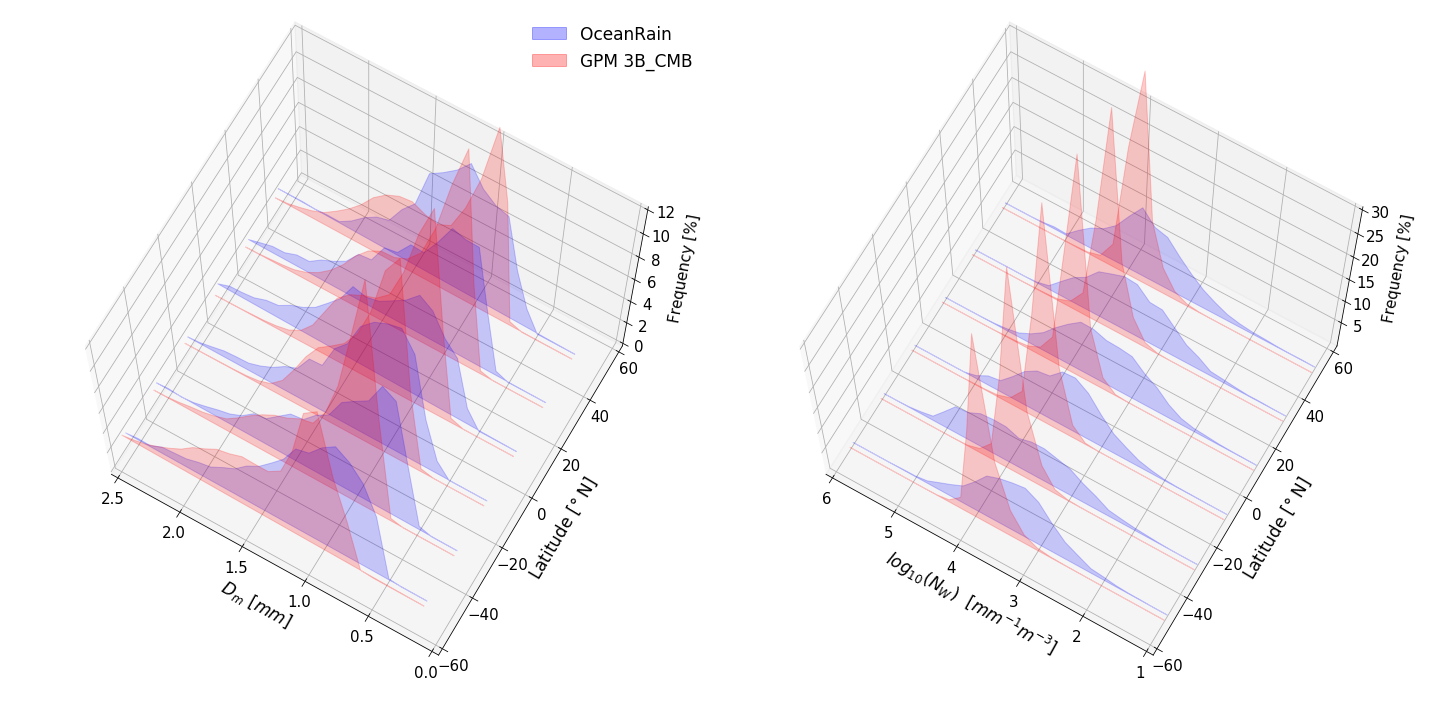

In [36]:

# Dm first
or_hist_dm[22:,nlt-1] = .007  # just a weird rendering thing... otherwise small values look negative on plot
plohist1 = np.zeros([nb-5,nlt*2])
plohist1[:,0:(2*nlt-1):2] = nhist[0:nb-5,:]
plohist1[:,1:(2*nlt):2] = or_hist_dm[0:nb-5,:nlt]
    
xs1 = binz[nb-5:0:-1] 
verts1 = []
for z in range(nlt*2):
    ys1 = plohist1[::-1,z]*100.0
    verts1.append(list(zip(xs1, ys1)))

fig2 = plt.figure(figsize=[20,10]) #figsize=plt.figaspect(0.5))

ax21 = fig2.add_subplot(1, 2, 1, projection='3d')
poly1 = PolyCollection(verts1, facecolors=[cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b'), 
                                         cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b')],
                     edgecolors=[ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), 
                                 ce('r'),ce('b'), ce('r'),ce('b')])
poly1.set_alpha(0.2)
ax21.add_collection3d(poly1, zs=zs, zdir='y')

fs=15
lapd = 13 # label pad, to keep from overlapping with tick labels
ax21.set_xlabel('$D_m$ [$mm$]',fontsize=fs+2,labelpad=lapd)
ax21.set_xlim3d(2.5, 0)
ax21.set_ylabel('Latitude [$\degree$ N]',fontsize=fs+2,labelpad=lapd+2)
ax21.set_ylim3d(minlat,maxlat)
ax21.set_zlabel('Frequency [%]',fontsize=fs,labelpad=lapd)
ax21.set_zlim3d(0.0, 12)
ax21.view_init(elev=70.)
ax21.tick_params(labelsize=fs,axis='both')

plt.legend(handles=[red_patch,blue_patch],fontsize=fs+2, loc='upper right', frameon=False)

# And Nw
plohist2 = np.zeros([30-4,nlt*2])
plohist2[:,0:(nlt*2-1):2] = nhist_nw[0:(30-4),:]
plohist2[:,1:(nlt*2):2] = or_hist_nw[0:(30-4),:nlt]
plt.tight_layout()
    
xs2 = nbnz[0:30-4][::-1] 
print(xs2)
verts2 = []
for z in range(nlt*2):
    ys2 = plohist2[::-1,z]*100.0
    verts2.append(list(zip(xs2, ys2)))

#fig2 = plt.figure(figsize=[10,10])
ax22 = fig2.add_subplot(1, 2, 2, projection='3d')
poly2 = PolyCollection(verts2, facecolors=[cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b'), 
                                         cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b')],
                     edgecolors=[ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), 
                                 ce('r'),ce('b'), ce('r'),ce('b')])
poly2.set_alpha(0.2)
ax22.add_collection3d(poly2, zs=zs, zdir='y')

ax22.set_xlabel('$log_{10}(N_W)$  [$mm^{-1} m^{-3}$]',fontsize=fs+2,labelpad=lapd)
ax22.set_xlim3d(np.max(nbnz)-1, np.min(nbnz))
ax22.set_ylabel('Latitude [$\degree$ N]',fontsize=fs+2,labelpad=lapd+2)
ax22.set_ylim3d(minlat,maxlat)
ax22.set_zlabel('Frequency [%]',fontsize=fs,labelpad=lapd)
ax22.set_zlim3d(0.01, 30)
ax22.view_init(elev=70.)
ax22.tick_params(labelsize=fs,axis='both')
#plt.legend(handles=[red_patch,blue_patch],fontsize=fs-1,loc='upper left')

plt.tight_layout()

fig2.savefig('img/2pan_3d_GPMcmb_v3.png',dpi=200,bbox_inches="tight")

plt.show()
andstop

[0.         0.         0.         0.         0.01804692 0.04712252
 0.08842992 0.09163826 0.09965911 0.11469822 0.10366954 0.09584921
 0.089232   0.05795067 0.04712252 0.03168237 0.02867455 0.02205735
 0.01323441 0.0066172  0.00681773 0.00621616 0.007      0.007
 0.007      0.007      0.007      0.007      0.007      0.007     ]
[0.         0.         0.         0.         0.         0.0011853
 0.04692919 0.08567101 0.14116072 0.13262215 0.08949032 0.06249177
 0.0546117  0.05476535 0.05524825 0.050968   0.04826814 0.04157338
 0.03566882 0.02691075 0.02056719 0.01507968 0.01042627 0.00750691
 0.00548751 0.00401686 0.00307301 0.002195   0.00147065 0.00261205]


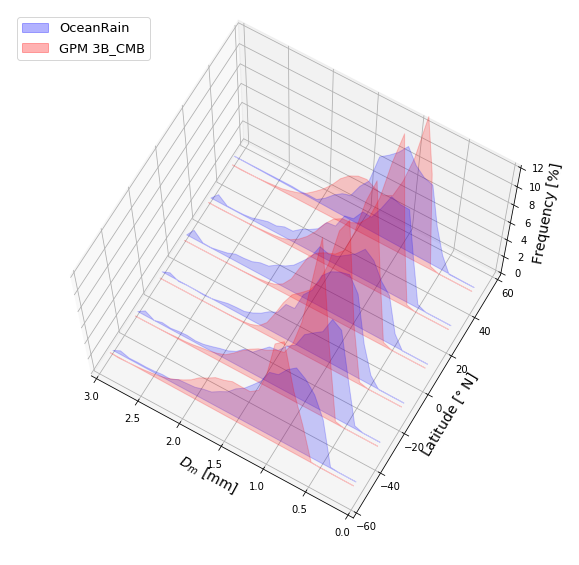

In [8]:

or_hist_dm[22:,nlt-1] = .007  
 # just a weird graphics rendering thing... otherwise small values look negative on plot
plohist = np.zeros([nb,nlt*2])
plohist[:,0:(2*nlt-1):2] = nhist
plohist[:,1:(2*nlt):2] = or_hist_dm[:,:nlt]
print(or_hist_dm[:,nlt-1])
#andstop
#verts[verts < .5] = 0.0 # make it easier on plotting routine
print(plohist[:,0])
    
xs = binz[::-1] 
verts = []
for z in range(2*nlt):
    ys = plohist[::-1,z]*100.0 #np.random.rand(len(xs))
    verts.append(list(zip(xs, ys)))

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
poly = PolyCollection(verts, facecolors=[cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b'), 
                                         cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b')],
                     edgecolors=[ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), 
                                 ce('r'),ce('b'), ce('r'),ce('b')])
poly.set_alpha(0.2)
ax.add_collection3d(poly, zs=zs, zdir='y')

fs = 14
ax.set_xlabel('$D_m$ [mm]',fontsize=fs)
ax.set_xlim3d(3, 0)
ax.set_ylabel('Latitude [$\degree$ N]',fontsize=fs)
ax.set_ylim3d(minlat,maxlat)
ax.set_zlabel('Frequency [%]',fontsize=fs)
ax.set_zlim3d(0.0, 12)
ax.view_init(elev=70.)#,azim=0) # adjust elevation and azimuth angles for 3d plot view

plt.legend(handles=[red_patch,blue_patch],fontsize=fs-1,loc='upper left')

fig.savefig('img/3d_GPMcmb_Dm_v3.png',dpi=350,bbox_inches="tight")

plt.show()

In [ ]:
# putting together to make into a 2 panel figure
or_hist_dm[22:,nlt-1] = .007  
 # just a weird graphics rendering thing... otherwise small values look negative on plot
plohist = np.zeros([nb,nlt*2])
plohist[:,0:(2*nlt-1):2] = nhist
plohist[:,1:(2*nlt):2] = or_hist_dm[:,:nlt]
print(or_hist_dm[:,nlt-1])
#andstop
#verts[verts < .5] = 0.0 # make it easier on plotting routine
print(plohist[:,0])
    
xs = binz[::-1] 
verts = []
for z in range(2*nlt):
    ys = plohist[::-1,z]*100.0 #np.random.rand(len(xs))
    verts.append(list(zip(xs, ys)))

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
poly = PolyCollection(verts, facecolors=[cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b'), 
                                         cc('r'),cc('b'), cc('r'),cc('b'), cc('r'),cc('b')],
                     edgecolors=[ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), ce('r'),ce('b'), 
                                 ce('r'),ce('b'), ce('r'),ce('b')])
poly.set_alpha(0.2)
ax.add_collection3d(poly, zs=zs, zdir='y')

fs = 14
ax.set_xlabel('$D_m$ [mm]',fontsize=fs)
ax.set_xlim3d(3, 0)
ax.set_ylabel('Latitude [$\degree$ N]',fontsize=fs)
ax.set_ylim3d(minlat,maxlat)
ax.set_zlabel('Frequency [%]',fontsize=fs)
ax.set_zlim3d(0.0, 12)
ax.view_init(elev=70.)#,azim=0) # adjust elevation and azimuth angles for 3d plot view

plt.legend(handles=[red_patch,blue_patch],fontsize=fs-1,loc='upper left')

fig.savefig('img/3d_GPMcmb_Dm_v3.png',dpi=350,bbox_inches="tight")

plt.show()

In [ ]:
#
#print(np.shape(NwLo))
#print(NwLo[13,13])
#print(NwLoH[:,13,13])
#print(nbnz)
#
#print(info(mlowdm,0))
##print(info(DmLoS,0))
##plt.figure(figsize=[12,7])
##grdmap(np.transpose(DmLoS),-180,-70, 0, 0.6, 0) # just last month in loop, for example
#plt.figure(figsize=[12,7])
#grdmap(np.transpose(mlowdm),-180,-70, 0.9, 1.5, 0)
#
## conclusion: Less variability in Nw is seen by 3B-CMB!! (compared to OceanRAIN anyway)

In [ ]:
## can also look at the difference in either Dm or Nw as they change with height 
##  (taken with a grain of salt, of course)
##hsub = 2 # i.e. 1-2km level
##dmdif = DmLo[0,2,0,0,:,:] - DmLo[0,2,hsub,0,:,:] # near-sfc minus 1-2km
##Nwdif = NwLo[0,2,0,0,:,:] - NwLo[0,2,hsub,0,:,:] # near-sfc minus 1-2km
#dmdif = mlowdm_up - mlowdm
#print(info(dmdif,0))
##plt.figure(figsize=[12,8])
##grdmap(np.transpose(dmdif),-180,-70,-.1,.1,2)
##grdmap(np.transpose(Nwdif),-180,-70,-.25,.25,2)